In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt

# enter your exotic-ld path if it isn't already defined in your 
# environment variables. 
os.environ['EXO_LD_PATH'] = '/Users/tylergordon/research/exotic_ld_data'

from fit import fit_wlc, fit_spec
from plot_utils import get_wl_models 
from distributions import *

In [266]:
priors_dict = {
    'period': normal_prior(1.4015, 0.00018),
    'radius': normal_prior(0.0212, 0.001),
    't0': uniform_prior(0.05, 0.125, init=0.085),
    'semimajor_axis': normal_prior(7.61, 0.31),
    'inclination': normal_prior(85.8 * np.pi / 180, 0.8 * np.pi / 180),
    'eccentricity': uniform_prior(0.0, 0.21, init=0.01),
    'periastron': uniform_prior(0, np.pi, init=np.pi/2),
    'reference': 'https://ui.adsabs.harvard.edu/abs/2020A%26A...636A..58A/abstract'
}

st_params_dict = {
    'mh': 0.04,
    'logg': 4.04,
    'teff': 3800,
    'reference': 'https://ui.adsabs.harvard.edu/abs/2020A%26A...636A..58A/abstract'
}

base_dir = '/Users/tylergordon/research/compass/targets/175.01/T1/reduction/stage3/'

def load_all(prefix):

    time = np.load(base_dir + prefix + '_times.npy')
    time -= time[0]
    spec = np.load(base_dir + prefix + '.npy')
    cube = np.load(base_dir + prefix + '_cleaned_cube.npy')
    wavs = np.load(base_dir + prefix + '_wav.npy')

    return time, wavs, spec, cube

In [ ]:
key = [
    'GP, no PCA', 
    'GP, 2 PCA', 
    'GP, 4 PCA', 
    'GP, 6 PCA', 
    
    'no GP, no PCA', 
    'no GP, 2 PCA', 
    'no GP, 4 PCA', 
    'no GP, 6 PCA'
]

opts = [
    (True, 0), 
    (True, 2), 
    (True, 4),
    (True, 6),
    
    (False, 0), 
    (False, 2), 
    (False, 4),
    (False, 6)
]

def fit_wrapper(opts, detector):

    if detector is 'nrs1':
        prefix = '175.01_T1_nrs1'
    elif detector is 'nrs2':
        prefix = '175.01_T1_nrs2'

    time, wavs, spec, cube = load_all(prefix)
    
    return fit_wlc(
        time, 
        spec, 
        wavs, 
        priors_dict, 
        st_params_dict,
        detector, 
        cube=cube,
        gp=opts[0], 
        n_pca_components=opts[1],
        samples=10000, 
        burnin=5000, 
        nproc=2,
        save_chains=False,
    )

results_nrs1 = [fit_wrapper(o, 'nrs1') for o in opts]
results_nrs2 = [fit_wrapper(o, 'nrs2') for o in opts]

 70%|███████████████████████████████████████████████▏                   | 7045/10000 [03:54<01:58, 25.02it/s]

In [7]:
fit_spec_wrapper = lambda result: fit_spec(
    result,
    wav_per_bin=0.02, 
    samples=5000, 
    burnin=2000, 
    nproc=12, 
    n_pca_components_spec=0,
    save_chains=False,
    return_chains=True
)

spec_results_nrs1 = [fit_spec_wrapper(r) for r in results_nrs1]
spec_results_nrs2 = [fit_spec_wrapper(r) for r in results_nrs2]

running bands 61-67 of 67                                   

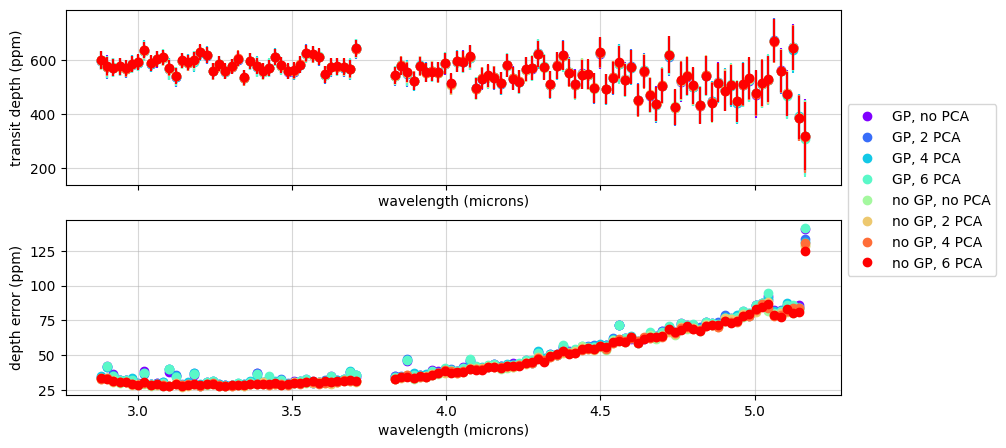

In [61]:
color_keys = np.linspace(0, 1, len(key))
colors = [plt.cm.rainbow(c) for c in color_keys]

chains_nrs1 = [r[0] for r in spec_results_nrs1]
wavs_nrs1 = spec_results_nrs1[0][1]
chains_nrs2 = [r[0] for r in spec_results_nrs2]
wavs_nrs2 = spec_results_nrs2[0][1]

fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

for k, color, chain in zip(key, colors, chains_nrs1):
    
    rp = np.array([np.mean(chain.get_chain()[:, :, 0], axis=(0, 1)) for chain in chain])
    err = np.array([np.std(chain.get_chain()[:, :, 0], axis=(0, 1)) for chain in chain])
    
    dep = rp**2 * 1e6
    dep_err = 2 * rp * err * 1e6
    
    axs[0].plot(wavs_nrs1, dep, 'o', color=color)
    axs[0].errorbar(wavs_nrs1, dep, yerr=dep_err, color=color, ls='none')
    axs[0].grid(alpha=0.5)
    axs[0].set_ylabel('transit depth (ppm)')
    axs[0].set_xlabel('wavelength (microns)')
    axs[0].legend()

    axs[1].plot(wavs_nrs1, dep_err, 'o', color=color)
    axs[1].grid(alpha=0.5)
    axs[1].set_ylabel('depth error (ppm)')
    axs[1].set_xlabel('wavelength (microns)')

for k, color, chain in zip(key, colors, chains_nrs2):
    
    rp = np.array([np.mean(chain.get_chain()[:, :, 0], axis=(0, 1)) for chain in chain])
    err = np.array([np.std(chain.get_chain()[:, :, 0], axis=(0, 1)) for chain in chain])
    
    dep = rp**2 * 1e6
    dep_err = 2 * rp * err * 1e6

    axs[0].plot(wavs_nrs2, dep, 'o', color=color, label=k)
    axs[0].errorbar(wavs_nrs2, dep, yerr=dep_err, color=color, ls='none')
    axs[0].grid(alpha=0.5)
    axs[0].set_ylabel('transit depth (ppm)')
    axs[0].set_xlabel('wavelength (microns)')
    axs[0].legend(bbox_to_anchor=(1.0, 0.5))
    #axs[0].set_ylim(450, 700)

    axs[1].plot(wavs_nrs2, dep_err, 'o', color=color)
    axs[1].grid(alpha=0.5)
    axs[1].set_ylabel('depth error (ppm)')
    axs[1].set_xlabel('wavelength (microns)')

    #axs[1].set_ylim(25, 50)

In [64]:
for k, color, chain in zip(key, colors, chains_nrs2):

    rp = np.array([np.mean(chain.get_chain()[:, :, 0], axis=(0, 1)) for chain in chain])
    err = np.array([np.std(chain.get_chain()[:, :, 0], axis=(0, 1)) for chain in chain])
    
    dep = rp**2 * 1e6
    dep_err = 2 * rp * err * 1e6
    mean_dep_err = np.mean(dep_err)
    print(k + ': {:0.2f}'.format(mean_dep_err))

GP, no PCA: 59.97
GP, 2 PCA: 59.82
GP, 4 PCA: 59.78
GP, 6 PCA: 60.04
no GP, no PCA: 57.67
no GP, 2 PCA: 57.77
no GP, 4 PCA: 57.77
no GP, 6 PCA: 57.52


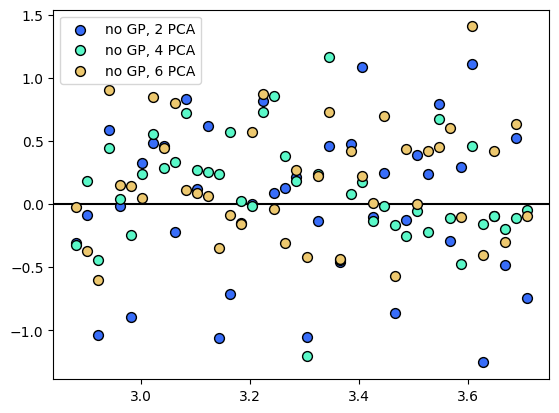

In [59]:
chain0 = chains_nrs1[4]
rp = np.array([np.mean(chain.get_chain()[:, :, 0], axis=(0, 1)) for chain in chain0])
err = np.array([np.std(chain.get_chain()[:, :, 0], axis=(0, 1)) for chain in chain0])
dep_err0 = 2 * rp * err * 1e6

plt.axhline(0, color='k', zorder=-10)

for color, k, chain in zip(colors[1::2], key[5:], chains_nrs1[5:]):
    rp = np.array([np.mean(chain.get_chain()[:, :, 0], axis=(0, 1)) for chain in chain])
    err = np.array([np.std(chain.get_chain()[:, :, 0], axis=(0, 1)) for chain in chain])
    
    dep = rp**2 * 1e6
    dep_err = 2 * rp * err * 1e6
    plt.scatter(wavs_nrs1, dep_err - dep_err0, color=color, label=k, edgecolor='k', s=50)
    plt.legend()
